In [73]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical  

# (training_data, training_labels), (testing_data, testing_labels) = (cifar100.load_data("coarse"))

# centre the data
def centre_data(train, test):
    
    # calculate the means for each attribute of the training data
    column_means = np.mean(train, axis=0) 
    
    # centre training data by subtracting training data attribute means
    for i in range(len(train)):
        train[i] = train[i] - column_means
    
    # centre testing data by subtracting training data attribute means
    for x in range(len(test)):
        test[x] = test[x] - column_means
        
    return train, test

# apply PCA on the data 
def PCA(variance_target, training_data, testing_data):

    U, sigma, Vt = np.linalg.svd(training_data, full_matrices=False)
    
    sum_square_singular = np.sum(sigma**2)
    
    ratios = sigma**2/sum_square_singular
    
                
    n_components = 0
    explained_variance = 0
    
    # determine how many principle components must be retained to maintain the target level of explained variance
    for i in range(len(ratios)):
        if explained_variance >= variance_target:
            break
        else: 
            n_components += 1
            explained_variance += ratios[i]
    
    return training_data.dot(Vt.T[:, :n_components]), testing_data.dot(Vt.T[:, :n_components])

def increase_image_contrast(image):
    xp = [0, 64, 128, 192, 255]
    fp = [0, 16, 128, 240, 255]
    x = np.arange(256)
    table = np.interp(x, xp, fp).astype('uint8')
    return cv2.LUT(image, table)

def increase_all_contrast(train, test):
    new_train = np.copy(train)
    new_test = np.copy(test)
    for i in range(len(train)):
        new_train[i] = increase_image_contrast(train[i])
    for i in range(len(test)):
        new_test[i] = increase_image_contrast(test[i])
    return new_train, new_test

(training_data, training_labels), (testing_data, testing_labels) = (cifar100.load_data("coarse"))

# Transform images from (32,32,3) to 3072-dimensional vectors (32*32*3)

training_data = np.reshape(training_data,(50000, 3072))
testing_data = np.reshape(testing_data,(10000, 3072))


training_data = training_data.astype('float32')
testing_data = testing_data.astype('float32')

training_data, testing_data = centre_data(training_data, testing_data)

training_data, testing_data = PCA(0.8, training_data, testing_data)


Epoch 1/15
1250/1250 - 4s - loss: 2.4628 - accuracy: 0.2464 - val_loss: 2.3378 - val_accuracy: 0.2841
Epoch 2/15
1250/1250 - 3s - loss: 2.3093 - accuracy: 0.2900 - val_loss: 2.2775 - val_accuracy: 0.3017
Epoch 3/15
1250/1250 - 3s - loss: 2.2488 - accuracy: 0.3096 - val_loss: 2.2705 - val_accuracy: 0.3070
Epoch 4/15
1250/1250 - 3s - loss: 2.2149 - accuracy: 0.3169 - val_loss: 2.2551 - val_accuracy: 0.3108
Epoch 5/15
1250/1250 - 3s - loss: 2.1915 - accuracy: 0.3264 - val_loss: 2.2699 - val_accuracy: 0.3043
Epoch 6/15
1250/1250 - 3s - loss: 2.1666 - accuracy: 0.3333 - val_loss: 2.2539 - val_accuracy: 0.3198
Epoch 7/15
1250/1250 - 3s - loss: 2.1484 - accuracy: 0.3374 - val_loss: 2.2446 - val_accuracy: 0.3187
Epoch 8/15
1250/1250 - 3s - loss: 2.1231 - accuracy: 0.3451 - val_loss: 2.2135 - val_accuracy: 0.3258
Epoch 9/15
1250/1250 - 3s - loss: 2.1040 - accuracy: 0.3519 - val_loss: 2.2758 - val_accuracy: 0.3231
Epoch 10/15
1250/1250 - 3s - loss: 2.0884 - accuracy: 0.3562 - val_loss: 2.2542 - 

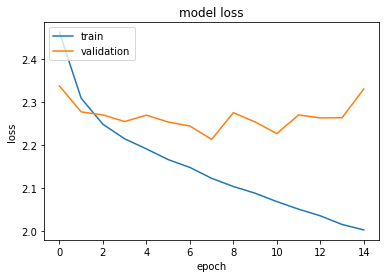

['loss', 'accuracy']
[2.3318333625793457, 0.31189998984336853]


In [74]:
# Normalization of pixel values (to [0-1] range)

training_labels = to_categorical(training_labels, 20)
testing_labels = to_categorical(testing_labels, 20)

training_data /= 255
testing_data /= 255



model = Sequential()

model.add(Dense(256, activation='elu', input_dim=training_data.shape[1]))

model.add(Dense(256, activation='elu'))

model.add(Dense(20, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(training_data, training_labels, epochs=15, batch_size=32, verbose=2, validation_split=0.2)

def plotLosses(history):  
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
plotLosses(history)

score = model.evaluate(testing_data, testing_labels, batch_size=128, verbose=0)

print(model.metrics_names)
print(score)